In [3]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from skimage.feature import hog
from skimage import exposure
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [4]:
ground_truth_data = pd.read_csv("archive/ISIC_2019_Training_GroundTruth.csv")
print(ground_truth_data.shape)
ground_truth_data.head()

(25331, 10)


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


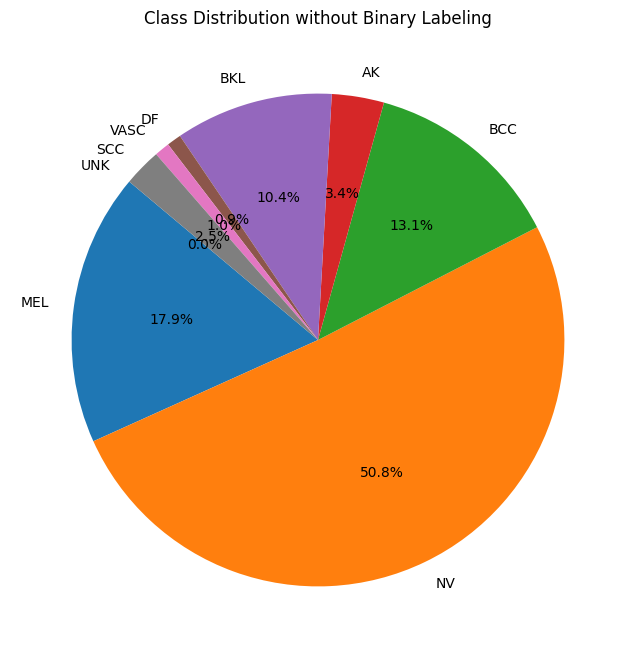

In [5]:
class_distribution = ground_truth_data.iloc[:, 1:].sum()

plt.figure(figsize=(8, 8))
plt.pie(
    class_distribution,
    labels=class_distribution.index,
    autopct='%1.1f%%',
    startangle=140
)
plt.title("Class Distribution without Binary Labeling")
plt.show()


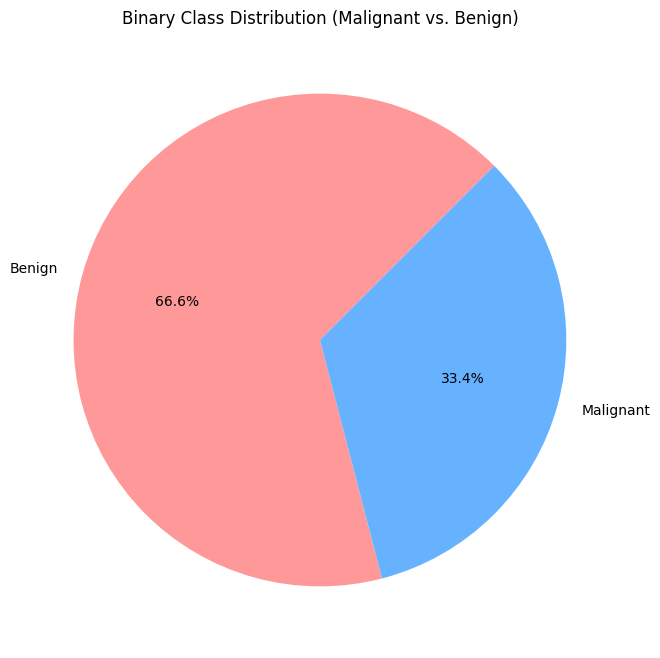

          image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK binary_label
0  ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0       Benign
1  ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0       Benign
2  ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0    Malignant
3  ISIC_0000003  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0       Benign
4  ISIC_0000004  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0    Malignant


In [6]:
# Define malignant and benign classes based on the categories
malignant_classes = ['MEL', 'BCC', 'SCC']  # Malignant conditions
benign_classes = ['NV', 'AK', 'BKL', 'DF', 'VASC']  # Benign conditions

# Create a new binary column for classification
ground_truth_data['binary_label'] = ground_truth_data[malignant_classes].sum(axis=1).apply(
    lambda x: 'Malignant' if x > 0 else 'Benign'
)

# Calculate the class distribution for binary labels
binary_class_distribution = ground_truth_data['binary_label'].value_counts()

# Plot a pie chart for the binary class distribution
plt.figure(figsize=(8, 8))
plt.pie(
    binary_class_distribution,
    labels=binary_class_distribution.index,
    autopct='%1.1f%%',
    startangle=45,
    colors=['#FF9999', '#66B2FF']
)
plt.title("Binary Class Distribution (Malignant vs. Benign)")
plt.show()

print(ground_truth_data.head())


In [7]:
import cv2
import os
import numpy as np

# Path to save resized images
resized_dir = r'Dataset 3/resized_images'
os.makedirs(resized_dir, exist_ok=True)

# Generate a dictionary mapping image names to full paths
image_file_map = {os.path.basename(file).split('.')[0]: file for file in image_files}

# Target dimensions for resizing
target_dimensions = (224, 224)

# List to store resized images
resized_images = []

# Counter to track processed images
processed_count = 0

# Iterate through all image names in the ground truth data
for image_name in ground_truth_data['image']:
    # Get the full path from the dictionary
    image_path = image_file_map.get(image_name)
    if image_path:
        try:
            # Load the image using OpenCV
            image = cv2.imread(image_path)
            if image is not None:
                # Resize the image
                resized_image = cv2.resize(image, target_dimensions, interpolation=cv2.INTER_AREA)
                # Save the resized image to the new directory
                save_path = os.path.join(resized_dir, f"{image_name}.jpg")
                cv2.imwrite(save_path, resized_image)
                processed_count += 1
                print(processed_count)
            else:
                print(f"Warning: Unable to load image {image_path}. Skipping.")
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
    else:
        print(f"Warning: Image {image_name} not found in the directory. Skipping.")

# Output the number of successfully resized images
print(f"Processed and saved {processed_count} images to {resized_dir}")


NameError: name 'image_files' is not defined

In [ ]:
import glob
from sklearn.model_selection import train_test_split

# Path to the resized images directory
resized_dir = r'Dataset 3/resized_images'

# Get all resized image file paths
try:
    resized_image_paths = glob.glob(os.path.join(resized_dir, "*.jpg"))
    print(f"Found {len(resized_image_paths)} resized images.")
except Exception as e:
    print(f"Error accessing resized images directory: {e}")
    resized_image_paths = []

# Extract image names (without extensions)
resized_image_names = [os.path.basename(path).split('.')[0] for path in resized_image_paths]

# Filter ground truth data to match resized images
filtered_ground_truth = ground_truth_data[ground_truth_data['image'].isin(resized_image_names)]

# Check if filtered data matches
if not filtered_ground_truth.empty:
    # Create paths and labels for the resized images
    image_paths = [os.path.join(resized_dir, f"{name}.jpg") for name in filtered_ground_truth['image']]
    labels = filtered_ground_truth['binary_label'].values

    # Perform train-validation split
    try:
        X_train, X_val, y_train, y_val = train_test_split(
            image_paths, labels, test_size=0.3, random_state=42, stratify=labels
        )
        print(f"Training set size: {len(X_train)}, Validation set size: {len(X_val)}")
    except Exception as e:
        print(f"Error during train-test split: {e}")
else:
    print("Filtered ground truth data is empty. Ensure resized images match the dataset.")


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import pandas as pd

# Correctly initialize the data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1. / 255,  # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1. / 255  # Normalize pixel values
)

# Assuming X_train, y_train, X_val, y_val are pre-defined lists of filenames and labels
train_df = pd.DataFrame({'filename': X_train, 'class': y_train})
val_df = pd.DataFrame({'filename': X_val, 'class': y_val})

# Define target image size
target_size = (224, 224)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=target_size,
    batch_size=64,
    class_mode='binary'  # For binary classification
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=target_size,
    batch_size=64,
    class_mode='binary'  # For binary classification
)

# Debugging: Print class distribution
print("Train class distribution:\n", train_df['class'].value_counts())
print("Validation class distribution:\n", val_df['class'].value_counts())

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),  # Use Adam optimizer with a lower learning rate
              loss='binary_crossentropy',  # Binary crossentropy for binary classification
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

# Plot training and validation metrics
import matplotlib.pyplot as plt

history_dict = history.history

# Plot training and validation loss
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Save the model
model.save("binary_classification_model.h5")

# Preprocessing

In [10]:
import cv2
import os
import glob
import pandas as pd

# Paths
image_dir = os.path.join('archive', 'ISIC_2019_Training_Input')
preprocessed_dir = os.path.join('Dataset 3', 'preprocessed_images')
os.makedirs(preprocessed_dir, exist_ok=True)

# Print current working directory and absolute paths
print(f"Current working directory: {os.getcwd()}")
print(f"Image directory absolute path: {os.path.abspath(image_dir)}")

# Load ground truth data
ground_truth_csv_path = os.path.join('archive', 'ISIC_2019_Training_GroundTruth.csv')
print(f"Ground truth CSV path: {os.path.abspath(ground_truth_csv_path)}")
ground_truth_data = pd.read_csv(ground_truth_csv_path)
ground_truth_data['image'] = ground_truth_data['image'].str.strip().str.lower()

# Define the list of image extensions
image_extensions = ['*.jpg', '*.jpeg', '*.png']

# Use recursive glob to find all image files
image_files = []
for ext in image_extensions:
    image_files.extend(glob.glob(os.path.join(image_dir, '**', ext), recursive=True))

print(f"Found {len(image_files)} image files in {image_dir} and its subdirectories after filtering for image files.")

# Create image file map using filtered image files
image_file_map = {}
for file in image_files:
    base_name = os.path.splitext(os.path.basename(file))[0].strip().lower()
    image_file_map[base_name] = file

# Verify the number of images
expected_number_of_images = 25331
actual_number_of_images = len(image_files)
print(f"Expected number of images: {expected_number_of_images}")
print(f"Actual number of images found: {actual_number_of_images}")

# Sample keys from image_file_map
print("Sample keys from image_file_map:")
for key in list(image_file_map.keys())[:5]:
    print(key)

print("Sample image names from ground_truth_data:")
print(ground_truth_data['image'].head())

# Target dimensions for resizing
target_dimensions = (224, 224)

# Preprocessing function
def preprocess_image(image):
    image_denoised = cv2.medianBlur(image, 3)
    gray_image = cv2.cvtColor(image_denoised, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))
    blackhat = cv2.morphologyEx(gray_image, cv2.MORPH_BLACKHAT, kernel)
    image_inpainted = cv2.inpaint(image, blackhat, 1, cv2.INPAINT_TELEA)
    resized_image = cv2.resize(image_inpainted, target_dimensions, interpolation=cv2.INTER_AREA)
    return resized_image

# Process images
processed_count = 0
skipped_images = []

for image_name in ground_truth_data['image']:
    image_name = image_name.strip().lower()
    image_path = image_file_map.get(image_name)
    if image_path:
        try:
            # Load and preprocess the image
            image = cv2.imread(image_path)
            if image is not None:
                preprocessed_image = preprocess_image(image)
                save_path = os.path.join(preprocessed_dir, f"{image_name}.jpg")
                cv2.imwrite(save_path, preprocessed_image)
                processed_count += 1
                # print(f"Processed {processed_count}: {image_name}")
            else:
                print(f"Warning: Unable to load image {image_path}. Skipping.")
                # skipped_images.append(image_name)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            # skipped_images.append(image_name)
    else:
        print(f"Warning: Image {image_name} not found in the directory. Skipping.")
        # skipped_images.append(image_name)

# Output results
print(f"Processed and saved {processed_count} images to {preprocessed_dir}")
print(f"Skipped {len(skipped_images)} images: {skipped_images}")


Current working directory: /home/namitjain07/Desktop/prg
Image directory absolute path: /home/namitjain07/Desktop/prg/archive/ISIC_2019_Training_Input
Ground truth CSV path: /home/namitjain07/Desktop/prg/archive/ISIC_2019_Training_GroundTruth.csv
Found 25331 image files in archive/ISIC_2019_Training_Input and its subdirectories after filtering for image files.
Expected number of images: 25331
Actual number of images found: 25331
Sample keys from image_file_map:
isic_0024790
isic_0055215
isic_0053863
isic_0057762
isic_0000341
Sample image names from ground_truth_data:
0    isic_0000000
1    isic_0000001
2    isic_0000002
3    isic_0000003
4    isic_0000004
Name: image, dtype: object
Processed and saved 25331 images to Dataset 3/preprocessed_images
Skipped 0 images: []


### Contrast Streching

In [11]:
import cv2
import os
import glob
import numpy as np
 
# Paths
input_dir = os.path.join('Dataset 3', 'preprocessed_images')
output_dir = os.path.join('Dataset 3', 'contrast_stretched_images')
os.makedirs(output_dir, exist_ok=True)

# Define the contrast stretching function
def contrast_stretching(image):
    # Split image into R, G, B channels
    b, g, r = cv2.split(image)
    
    def stretch_channel(channel):
        mean_val = np.mean(channel)
        std_val = np.std(channel)
        low_in = mean_val - 0.4 * std_val  # lower limit for contrast stretching
        high_in = mean_val + 0.4 * std_val  # upper limit for contrast stretching
        # Avoid division by zero
        if high_in - low_in == 0:
            stretched = np.zeros_like(channel)
        else:
            stretched = np.clip((channel - low_in) * (255 / (high_in - low_in)), 0, 255)
        return stretched.astype(np.uint8)
    
    # Apply stretching to each channel
    r_stretched = stretch_channel(r)
    g_stretched = stretch_channel(g)
    b_stretched = stretch_channel(b)
    
    # Merge the channels back
    return cv2.merge([b_stretched, g_stretched, r_stretched])

# Get all image files in the input directory
image_files = glob.glob(os.path.join(input_dir, '*.*'))
print(f"Found {len(image_files)} images in {input_dir}")

# Process images
processed_count = 0
skipped_images = []

for image_path in image_files:
    try:
        image = cv2.imread(image_path)
        if image is not None:
            # Apply contrast stretching
            stretched_image = contrast_stretching(image)
            # Save the processed image
            image_name = os.path.basename(image_path)
            save_path = os.path.join(output_dir, image_name)
            cv2.imwrite(save_path, stretched_image)
            processed_count += 1
            print(f"Processed {processed_count}: {image_name}")
        else:
            print(f"Warning: Unable to load image {image_path}. Skipping.")
            skipped_images.append(image_path)
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        skipped_images.append(image_path)

# Output results
print(f"Processed and saved {processed_count} images to {output_dir}")
if skipped_images:
    print(f"Skipped {len(skipped_images)} images due to errors.")

Found 25331 images in Dataset 3/preprocessed_images
Processed 1: isic_0060577.jpg
Processed 2: isic_0028499.jpg
Processed 3: isic_0060459.jpg
Processed 4: isic_0010607.jpg
Processed 5: isic_0053542.jpg
Processed 6: isic_0024731.jpg
Processed 7: isic_0066569.jpg
Processed 8: isic_0026783.jpg
Processed 9: isic_0028668.jpg
Processed 10: isic_0029952.jpg
Processed 11: isic_0025265.jpg
Processed 12: isic_0030051.jpg
Processed 13: isic_0065635.jpg
Processed 14: isic_0054569.jpg
Processed 15: isic_0012334_downsampled.jpg
Processed 16: isic_0027843.jpg
Processed 17: isic_0029715.jpg
Processed 18: isic_0063428.jpg
Processed 19: isic_0058128.jpg
Processed 20: isic_0013421_downsampled.jpg
Processed 21: isic_0004715_downsampled.jpg
Processed 22: isic_0062116.jpg
Processed 23: isic_0029823.jpg
Processed 24: isic_0015416_downsampled.jpg
Processed 25: isic_0065235.jpg
Processed 26: isic_0059916.jpg
Processed 27: isic_0015992_downsampled.jpg
Processed 28: isic_0058686.jpg
Processed 29: isic_0065024.jp

In [12]:
import cv2
import os

def otsu_thresholding(image):
    # Convert image to grayscale if not already
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply OTSU thresholding
    _, segmented_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    return segmented_image

# Paths
input_folder = "Dataset 3/contrast_stretched_images"
output_folder = "Dataset 3/segmented_images"

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Process each image in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)
        
        # Read the image
        image = cv2.imread(input_path)
        if image is None:
            print(f"Failed to read {filename}, skipping.")
            continue
        
        # Apply Otsu's thresholding
        segmented_image = otsu_thresholding(image)
        
        # Save the processed image
        cv2.imwrite(output_path, segmented_image)

print("Processing completed. Processed images are saved in 'segmented_images'.")

Processing completed. Processed images are saved in 'segmented_images'.


In [13]:
from scipy.stats import skew, kurtosis
import cv2
import numpy as np

def extract_color_features(image):
    # Check if the image has 3 channels (RGB)
    if len(image.shape) == 3 and image.shape[2] == 3:  # Ensure the image is not grayscale
        # Convert the image to different color spaces
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
        rgb_image = image  # Keep the original RGB
    else:
        raise ValueError("Input image must be a color image with 3 channels (RGB)")

    # Function to calculate color statistics (mean, variance, skewness, kurtosis)
    def calculate_statistics(channel):
        return {
            'mean': np.mean(channel),
            'variance': np.var(channel),
            'skewness': skew(channel.flatten()),
            'kurtosis': kurtosis(channel.flatten())
        }

    # Initialize dictionary to store all features
    features = {}

    # Extract statistics for each channel in RGB
    for i, color in enumerate(['R', 'G', 'B']):
        stats = calculate_statistics(rgb_image[:, :, i])
        for stat, value in stats.items():
            features[f'{stat}_{color}'] = value

    # Extract statistics for each channel in HSV (Hue, Saturation, Value)
    for i, color in enumerate(['H', 'S', 'V']):
        stats = calculate_statistics(hsv_image[:, :, i])
        for stat, value in stats.items():
            features[f'{stat}_{color}'] = value

    # Add specific hue-based statistics
    hue_channel = hsv_image[:, :, 0]  # Hue channel
    features['mean_hue'] = np.mean(hue_channel)
    features['variance_hue'] = np.var(hue_channel)
    features['skewness_hue'] = skew(hue_channel.flatten())
    features['kurtosis_hue'] = kurtosis(hue_channel.flatten())

    # Extract statistics for each channel in Lab (L, A, B)
    for i, color in enumerate(['L', 'A', 'B']):
        stats = calculate_statistics(lab_image[:, :, i])
        for stat, value in stats.items():
            features[f'{stat}_{color}'] = value

    return features

In [14]:
from skimage.feature import hog
from skimage import exposure
import cv2

def extract_hog_features(image):
    # Resize the image for uniform HOG feature extraction
    resized_image = cv2.resize(image, (96, 128))

    # Extract HOG features
    if len(resized_image.shape) == 3 and resized_image.shape[2] == 3:
        hog_features, hog_image = hog(resized_image, pixels_per_cell=(8, 8), 
                                      cells_per_block=(1, 1), visualize=True, 
                                      orientations=18,  # Reduce orientations
                                      channel_axis=-1)
    else:
        hog_features, hog_image = hog(resized_image, pixels_per_cell=(8, 8), 
                                      cells_per_block=(1, 1), visualize=True, 
                                      orientations=18,  # Reduce orientations
                                      channel_axis=None)  # For grayscale images

    return hog_features